In [112]:
import math
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
from datetime import date, datetime
current_date = datetime.today().strftime('%Y-%m-%d')
import pandas_datareader
from pandas_datareader import data as pdr
import yfinance as yf
import datetime
yf.pdr_override()


In [113]:
company = 'NWG.L'

start = datetime.datetime(2012,1,1)
end = datetime.datetime(2020,1,1)

data = pdr.get_data_yahoo(company, start=start, end=end)
data

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2012-01-03,223.892303,226.519897,216.461502,226.261505,171.811584,8757003
2012-01-04,225.184601,227.230698,220.166107,223.569199,169.767181,6330518
2012-01-05,222.169205,226.261505,217.107605,218.292297,165.760178,7046407
2012-01-06,218.076904,223.612305,216.590698,220.876907,167.722778,5363087
2012-01-09,223.569199,225.766098,215.783005,216.138397,164.124573,8073036
...,...,...,...,...,...,...
2019-12-23,258.892303,261.046112,258.030701,260.292297,218.270081,25141160
2019-12-24,261.476898,262.446106,260.238403,261.369202,219.173111,2372182
2019-12-27,264.923004,266.861511,261.261505,261.261505,219.082794,8107739


In [114]:
# Prepare Data
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(data['Close'].values.reshape(-1,1))

training_days = 60 # Number of days to look back to train with 

x_train = []
y_train = []

for x in range(training_days, len(scaled_data)):
    x_train.append(scaled_data[x-training_days:x, 0])
    y_train.append(scaled_data[x, 0])

x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

In [115]:
# Build the Model
model = Sequential()

model.add(LSTM(50, return_sequences=True, input_shape=(x_train.shape[1], 1))) # return_sequences=True as we have layer after, input_shape=(60 ,1) - shape of training data.
model.add(LSTM(50, return_sequences=False)) # Increasing the depth increases the capacity of the model. 
model.add(Dense(25)) # Dense layer is deeply connected layer from its preceding layer which works for changing the dimension of the output by performing matrix vector multiplication
model.add(Dense(1)) # Prediction of the next closing price

model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x_train, y_train, epochs=1, batch_size=32)

# model.save('weights/final_model.pt')

2023-02-18 21:06:57.316865: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-18 21:06:57.739583: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-18 21:06:57.915508: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-18 21:06:58.123754: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-18 21:06:58.410293: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


62/62 [==============================] - 7s 63ms/step - loss: 0.0151


In [116]:
# Test the Model Accuracy
test_start = datetime.datetime(2020,1,1)
test_end = datetime.datetime.now()

test_data = pdr.get_data_yahoo(company, start=test_start, end=test_end)
actual_prices = test_data['Close'].values
total_dataset = pd.concat((data['Close'], test_data['Close']), axis=0)

model_inputs = total_dataset[len(total_dataset) - len(test_data) - training_days:].values
model_inputs = model_inputs.reshape(-1, 1)
model_inputs = scaler.transform(model_inputs)



[*********************100%***********************]  1 of 1 completed


In [119]:
# Make predictions on Test Data
x_test = []

for x in range(training_days, len(model_inputs)):
    x_test.append(model_inputs[x-training_days:x, 0])

# print(x_test)

x_test = np.array(x_test)

x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [120]:
predicted_prices = model.predict(x_test)
print(predicted_prices)

predicted_prices = scaler.inverse_transform(predicted_prices)

2023-02-18 21:07:45.799564: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-18 21:07:46.090186: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-18 21:07:46.366561: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


[[ 0.3683034 ]
 [ 0.36923388]
 [ 0.36922148]
 [ 0.3688464 ]
 [ 0.3683337 ]
 [ 0.36771306]
 [ 0.36680678]
 [ 0.3652254 ]
 [ 0.36274213]
 [ 0.35954487]
 [ 0.3551016 ]
 [ 0.34955212]
 [ 0.34389287]
 [ 0.33809125]
 [ 0.33275148]
 [ 0.32764482]
 [ 0.32235995]
 [ 0.31782058]
 [ 0.31315953]
 [ 0.30857334]
 [ 0.30467078]
 [ 0.3014819 ]
 [ 0.29842305]
 [ 0.295386  ]
 [ 0.29321882]
 [ 0.2916692 ]
 [ 0.29107544]
 [ 0.29088086]
 [ 0.29074556]
 [ 0.2907928 ]
 [ 0.29178843]
 [ 0.2935001 ]
 [ 0.2932615 ]
 [ 0.29105073]
 [ 0.28723648]
 [ 0.28234652]
 [ 0.27719548]
 [ 0.2715529 ]
 [ 0.2648593 ]
 [ 0.2573217 ]
 [ 0.24920471]
 [ 0.23957264]
 [ 0.22858185]
 [ 0.21618491]
 [ 0.20303012]
 [ 0.18957582]
 [ 0.17537068]
 [ 0.16070591]
 [ 0.14390959]
 [ 0.1264531 ]
 [ 0.10923114]
 [ 0.09057915]
 [ 0.07241104]
 [ 0.05471593]
 [ 0.03882198]
 [ 0.02425261]
 [ 0.01037934]
 [-0.00369261]
 [-0.01748736]
 [-0.0295547 ]
 [-0.03762293]
 [-0.04313344]
 [-0.04843365]
 [-0.05388255]
 [-0.05990403]
 [-0.06694121]
 [-0.07478

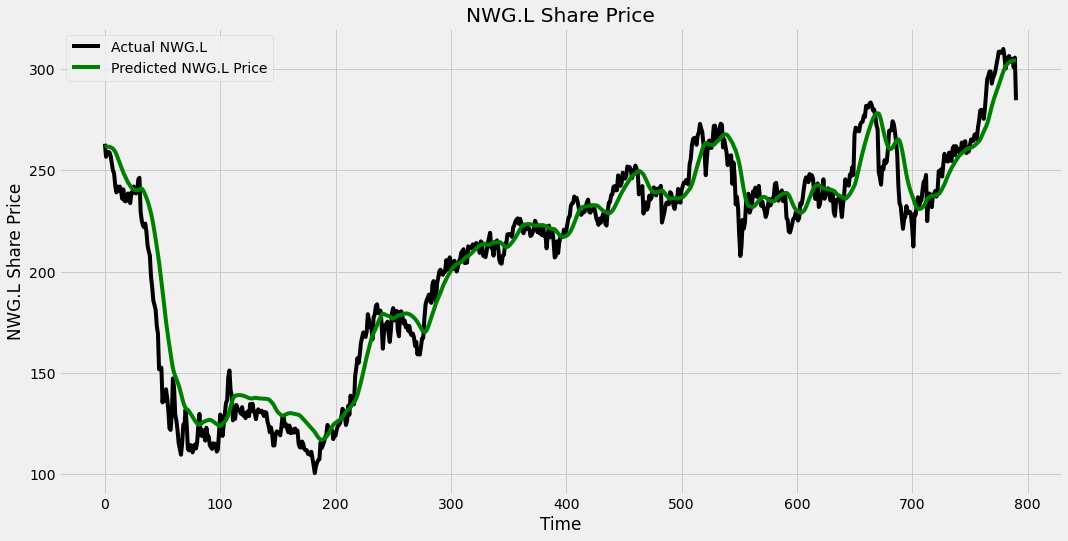

In [121]:
plt.figure(figsize=(16,8))
plt.plot(actual_prices, color='black', label=f"Actual {company}")
plt.plot(predicted_prices, color='green', label=f"Predicted {company} Price")
plt.title(f"{company} Share Price")
plt.xlabel('Time')
plt.ylabel(f"{company} Share Price")
plt.legend()
plt.show()

In [ ]:
# Predicting Next Day
real_data = [model_inputs[len(model_inputs) - training_days:len(model_inputs + 60), 0]]

real_data = np.array(real_data)
real_data = np.reshape(real_data, (real_data.shape[0], real_data.shape[1], 1))
print(real_data.shape)

# print(scaler.inverse_transform(real_data[-1]))

prediction = model.predict(real_data)
print(prediction.shape)
prediction = scaler.inverse_transform(prediction)
print(f"Prediction: {prediction}")

(1, 60, 1)
(1, 1)
Prediction: [[177.68419]]
